In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

# LASSO (Least Absolute Shrinkage and Selection Operator)
Ridge regression shrinks parameter estimates, but they never actually reach zero. LASSO works by trying to get small parameter estimates to zero (dropping them from the model). This prevents the overfitting of minutiae and works as an embedded filtering method. It's very handy when dealing with many (thousands or more) or predictors and need to allocate computing resources wisely.

The cost function for LASSO is:
$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j| $$

The difference between this and the ridge regression function is that it is penalizing by the sum of the absolute values of coefficients rather than the sum of squared coefficients. This means the penalty doesn't increase as swiftly for large coefficients as in ridge regression. Using the absolute value of the coefficient in the penalty is known as __"L1 regularization"__. 


#### Derivatives

Why does penalizing with the sum of absolute values lead to a solution with zero estimates for some parameters and the sum of squared does not? It has to do with derivatives. In OLS and ridge regression, the derivative used to find the optimal fit is the partial derivative of the cost function relative to the coefficients of B.

$$\frac{\partial}{\partial\beta}$$

This doesn't work for lasso because there are no derivates for when x = 0 in the lasso cost function. If you were to imagine the gradient descent operation, it would reach a "discontinuity" or "hole" where it would not know to where to continue.

#### How LASSO works

LASSO instead works by iteratively fitting a model to the data while excluding one of the features. It then checks how well the model reproduces the data, and if the model fit is good enough (with "good enough" determined by  λλ ) then the excluded feature is deemed unnecessary and its  ββ  is set to zero, effectively excluding it from the model. Otherwise, the excluded feature's  ββ  is set using a combination of the correlation of the feature with the model residuals ( ρjρj ) and  λ2λ2 and a new iteration begins, using the newly-computed  ββ  for the previously-excluded feature and excluding a new feature. This continues until the change in  ββ  is less than a pre-determined threshold.

Rather than gradient descent, LASSO uses coordinate descent to locate the holes. It does so by: 

1. Pick some starting values for $\beta$, often $\beta=0$. 

2. For each feature $j$ in $\beta$:
    * Predict the outcome using all features except for $j$.  
    * Look at how the residuals from the model using $\beta_{-j}$ (all betas except $j$) correlate with feature $j$. This correlation is called $\rho_j$.
    * If the correlation falls within an area enclosing 0 defined by $\lambda$, set $\beta_j=0$. (called *soft thresholding*)
    * If $\rho_j < \frac{\lambda}2$ set $\beta_j$ equal to $\rho_j + \frac{\lambda}2$
    * If $\rho_j > \frac{\lambda}2$ set $\beta_j$ equal to $\rho_j - \frac{\lambda}2$

In layman's terms, for each coefficient, if the correlation between the residuals resulting from the model with all other coefficients (except it) is between 0 and lambda, then set the coefficient equal to zero. If between 0 and lambda/2, set the coefficient equal to the correlation + (lambda/2). In other words, make it bigger. If the correlation is greater than lambda/2, set the coefficient equal to the correlation - (lambda/2). This will go through all of the features, then iterate again until the maximum difference between the parameter estimates and in the previous cycle and the current cycle is less than a predetermined threshold _tol_ (the default of which is 0.0001 in sklearn).

This leads to protection from overfitting by continually "shrinking" the model and by streamlining/reducing parameters (by setting some to zero).

#### Coded example:

In [8]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]

In [15]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.443633767129

Parameter estimates for the model with many features:
[  0.00000000e+00  -3.89351238e-01   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00  -2.77688887e-04
  -7.09158792e-07   3.48711577e+00]


In [16]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.445532251512
0.438046634591


#### Regularization param: Lasso

The lambda for lasso can vary between 0 (no penalty, acts like OLS) and infinity. If too large, all parameters will be set to zero.

Creating a plot to show how $r^2$ varies between different values for lambda.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]


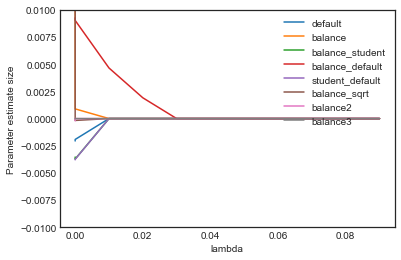

In [21]:
lassBig = linear_model.Lasso(alpha=0)
lassBig.fit(X_train2, Y_train)

# Store estimates.
estimates = np.append(lassBig.coef_, [0])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in np.arange(0, 0.1, 0.01):
    lassBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(lassBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.ylim(-.01, .01)
plt.show()

In [ ]:
estimates_df

In [ ]:
estimates

# Summary

Lasso and ridge regression are both clear improvements on OLS regression.  Ridge regression is an excellent tool to use with correlated features, while lasso is an efficient method of feature selection when dealing with an unmanageably large feature space. 